# Expectile regression: an alternative for quantile regression

As a data science practitioner, you may be familiar with the term "quantile regression". If so, you probably should know, that quantile objective can be considered as a generalization of **mean absolute error**. When MAE is used to estimate **conditional central tendency**, quantile objective serves to describe some other properties of the target variable distribution.

In this article, I'd like to present a slightly less known objective called **expectile**, being a generalized form of the **mean squared error** objective. 

## MAE vs MSE

In [4]:
Central tendency objective	Generalization	Related linear model algorithm	
Mean Absolute Error (MSE)	Quantile	Least Absolute Deviation (LAD)	
Mean Squared Error (MSE)	Expectile	Ordinary Least Squares (OLS)

SyntaxError: invalid syntax (3272262895.py, line 1)

╔════════════════════════════╦════════════════╦════════════════════════════════╗
║ Central tendency objective ║ Generalization ║ Related linear model algorithm ║
╠════════════════════════════╬════════════════╬════════════════════════════════╣
║ Mean Absolute Error (MSE)  ║ Quantile       ║ Least Absolute Deviation (LAD) ║
║ Mean Squared Error (MSE)   ║ Expectile      ║ Ordinary Least Squares (OLS)   ║
╚════════════════════════════╩════════════════╩════════════════════════════════╝

## Problem formulation - different characteristics of the target variable distribution

Let's assume we're solving a regression problem which is to predict the price of an real estate (a house or an apartment) based on its size. We create a re-usable function to generate a toy dataset. You can modify this function as you wish and try it on your own.

In [5]:
import pandas as pd
import numpy as np
from typing import Tuple, List

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

import scipy

np.random.seed(7)


def generate_offers(area_range: Tuple[int, int] = (20, 300), 
                    loc: float = 6000, 
                    scale: float = 3000,
                    samples: int = 2000):
    
    # Generate range of possible areas
    area_range = np.arange(area_range[0], area_range[1])
    
    # Generate probabilities of occurrence for different areas
    prob = scipy.stats.skewnorm.pdf(area_range, 
                                    a = -.5,
                                    loc = np.mean(area_range), 
                                    scale = np.std(area_range))
    prob = prob / prob.sum()
    samples = np.random.choice(area_range, samples, p=prob)
    
    # Generate prices per unit
    # We could also use lognormal distribution, but this way is more intuitive
    # from my point of view
    prices = scipy.stats.skewnorm.rvs(-.5, loc=loc, scale=scale, size=len(samples))
    # prices = np.random.normal(mean, sigma, size=len(samples))
    size = (prices < 3000).sum()
    prices[prices < 3000] = 3000 + np.random.normal(0, 500, size)
    prices[prices < 1000] = 1000 
    
    data = pd.DataFrame({
        'area': samples,
        'price': samples * prices
    })
    
    return data

data = generate_offers()

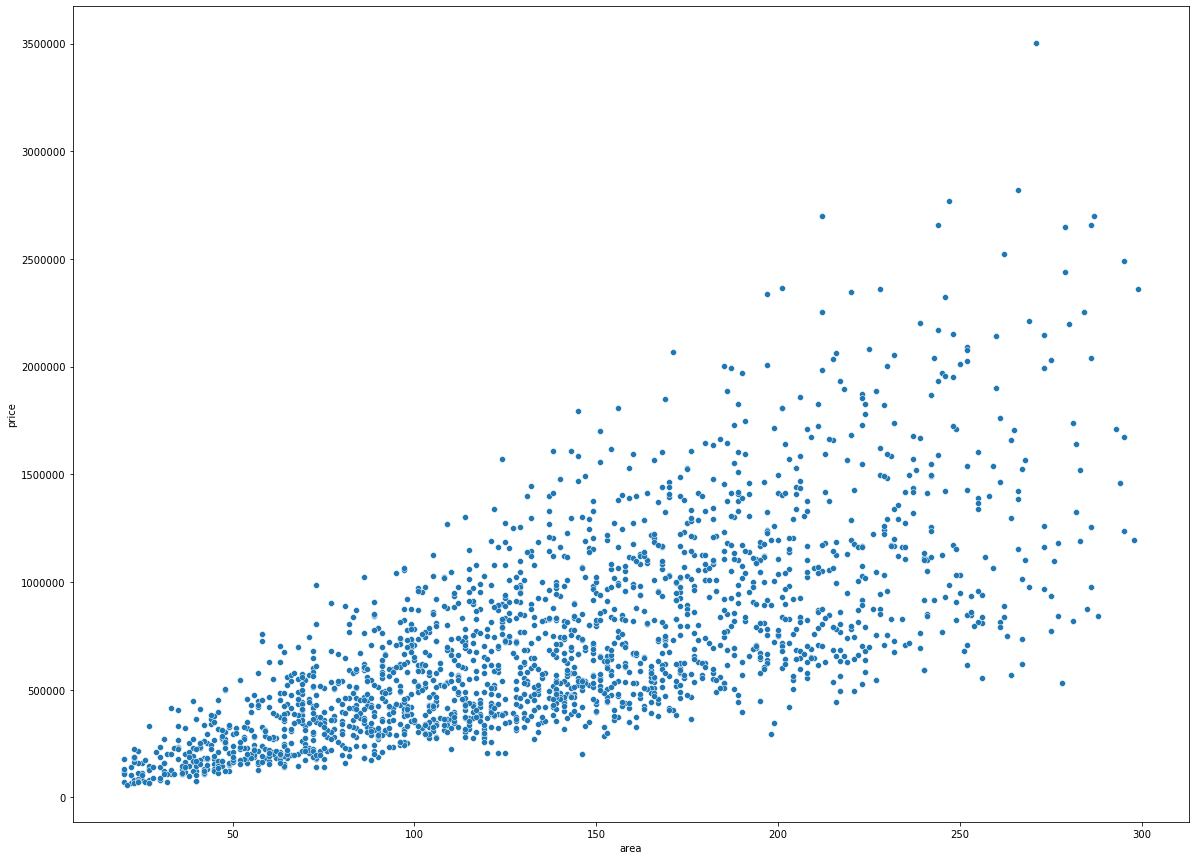

In [6]:
sns.scatterplot(data=data, x='area', y='price')
plt.show()
#plt.savefig('img/data.png')

In [7]:
data

,area,price
0,49,1.235548e+05
1,191,8.168215e+05
2,126,7.430453e+05
3,178,6.268150e+05
4,269,9.789406e+05
...,...,...
1995,127,1.250644e+06
1996,71,4.431406e+05
1997,242,1.116994e+06
1998,37,1.434236e+05


Now, let's answer the question - what should be the price of a real estate when its area equals 80 square meters?
*Hey, we have not enough data to conclude'*, you may say. We cannot estimate an accurate price based only on that one particular feature: area. We'd also like to know where the given reals estate actually is located (exact city/town), number of rooms, object's condition etc. You are totally right, but bear in mind we'll never have all the information to get rid of all the incertainty when calculating a prediction. So please consider this exercise just as an experiment.

Let's try to prepare an answer using three types of models:

* [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) - minimizing sum of squared errors (equivalently: MAE or RMSE)
* [LADRegression]() - a linear model, but minimizing sum of asbolute deviation (equivalently: MAE)
* [QuatileRegression]() - generalization of LADRegression.

I've used here classes from the scikit-lego library. I could also make use of statsmodel, but I'd like to keep it consistent and choose classes with sklearn-like API if possible. Of course, you can always write such objects from scratch.

In [8]:
from sklearn.linear_model import LinearRegression
from sklego.linear_model import LADRegression, QuantileRegression


models = {
    'ols_regression': LinearRegression(),
    'lad_regression': LADRegression(),
    'quantile_regression_20': QuantileRegression(quantile=.2),
    'quantile_regression_90': QuantileRegression(quantile=.9)
}

def linear_models(data: pd.DataFrame, 
                  models: dict,
                  features: List[str], 
                  target: List[str],
                  save: str = None):
    
    # Models
    for model_name, model in models.items():
        models[model_name].fit(data[features], data[target])

    # Forecasts
    space = np.linspace(data[features].min(), data[features].max()).reshape(-1, 1)
    pred = {'area': space.ravel()}
    
    for model_name, model in models.items():
        pred[model_name] = model.predict(space).ravel()
    
    pred = pd.DataFrame(pred)
    pred = pred.melt(features[0])

    sns.scatterplot(data=data, x=features[0], y=target[0], alpha=.7)
    sns.lineplot(data=pred, x=features[0], y='value', hue='variable', linewidth = 2)
    plt.legend(loc=2, prop={'size': 30})
    
    if save:
        plt.savefig(save)
    else:
        plt.show()

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnin

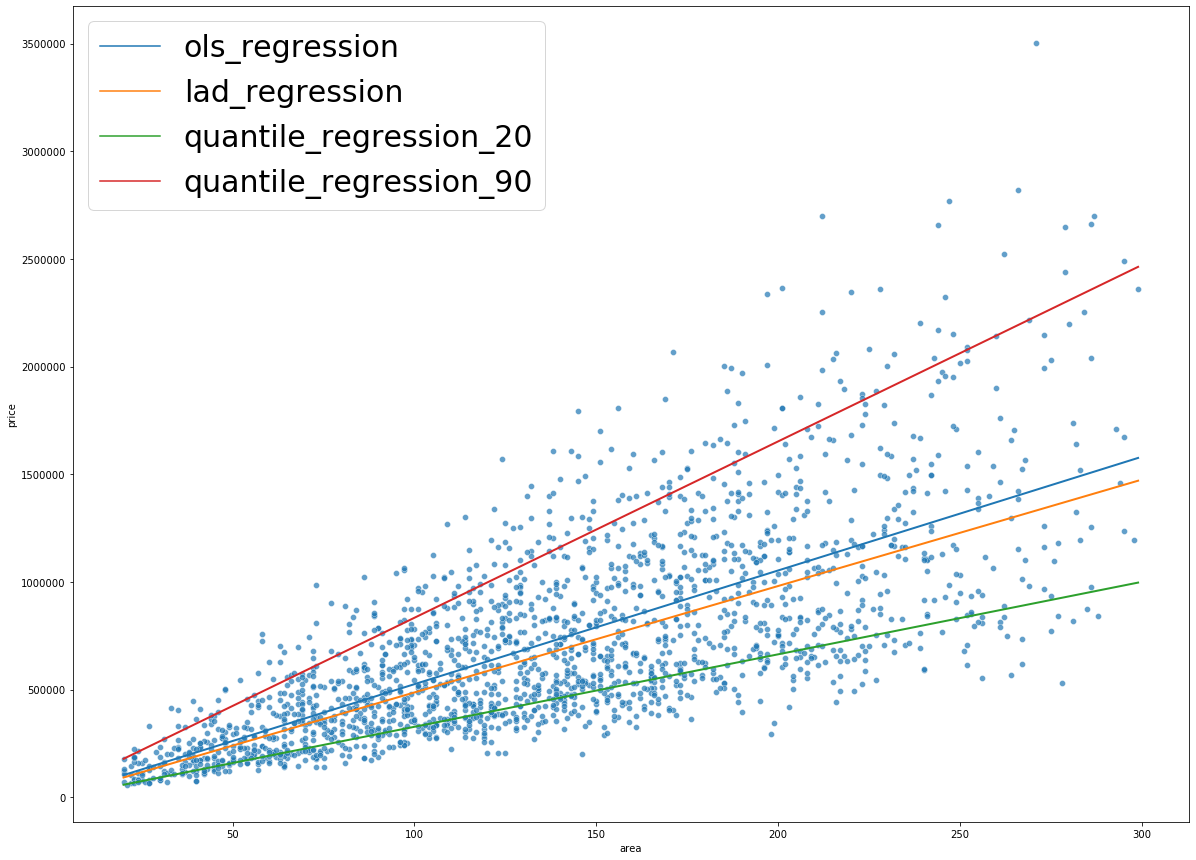

In [9]:
linear_models(
    data     = data, 
    models   = models, 
    features = ['area'], 
    target   = ['price'], 
    save     = 'img/linear_models.png'
)

We can see it gave us exactly the same results as calculating group-wise means. This is a special case, because we only have two area-related groups: 80 and 100 meters. If we have more, the values estimated with the LinearRegression would be not necessary identical.

The goal of doing this exercise was basically to show you, what answer we're looking for when trying to optimize MSE or, equivalently, RMSE. 

## MAE and quantile 

MAE objective function si defined as:

<center>$MAE = \frac{\sum \limits _{i=1} ^{n} |\| {n}$</center>
# https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/

Choosing a simple linear model with the most typical objective, we're looking for the **center of the distribution**, while qunatile regression gives us some information about the upper and lower bound of the target regression distribution. Obviously

In [10]:
# https://datascience.stackexchange.com/questions/66712/reason-for-generally-using-rmse-instead-of-mse-in-linear-regression

In [11]:
# https://stats.stackexchange.com/questions/532414/rmse-vs-mse-loss-function-the-optimization-solutions-are-equivalent
# https://real-statistics.com/multiple-regression/lad-regression/

## MSE vs expectile

In [12]:
# https://github.com/microsoft/LightGBM/blob/master/src/objective/regression_objective.hpp#L481

## Expectile from scratch

Finally, we'll try to construct a linear model optimizing expectile loss function. In the expression below, X is used to denote matrix of features extended with a vector of ones. Thus it suffices to perform dot product with a beta vector: intercept is already included. 

In [13]:
import numpy as np
from scipy.optimize import minimize


class ExpectileRegression:
    """Expectile regression with linear model"""
    
    def __init__(self, expectile: float =.5, **kwargs):
        assert 0 < expectile < 1, \
            f"e parameter must be stricly 0 < e < 1, but it equals: {expectile}"
        self.expectile = expectile
        super().__init__(**kwargs)
    
    def fit(self, X, y):
        
        if type(X) is pd.DataFrame:
            X = X.values
        
        if type(y) in [pd.DataFrame, pd.Series]:
            y = y.values
        
        # Adding column of ones
        n = X.shape[0]
        X = np.hstack([X, np.ones(shape=(n, 1))])
        
        self.beta = np.random.rand(X.shape[1])
        
        def expectile_loss(beta, *args):
            y_hat = X @ beta
            errors = y.reshape(-1, 1) - y_hat.reshape(-1, 1)
            return (
                    np.where(
                        errors < 0, 1 - self.expectile , self.expectile
                    ) * errors ** 2
                   ).mean()
        
        def expectile_grad(beta, *args):
            y_hat = X @ beta
            errors = y.reshape(-1, 1) - y_hat.reshape(-1, 1)
            return (
                    -2 * X.T @ (
                        np.where(
                            errors < 0, 1 - self.expectile , self.expectile
                        ) * errors
                      )
                    ) / X.shape[0]
        
        # Optimization
        res = minimize(
            fun    = expectile_loss,
            x0     = self.beta,
            args   = None,
            method = 'SLSQP' ,
            jac    = expectile_grad
        )
        
        self.beta = res.x
        
        return self
    
    def predict(self, X):
        n = X.shape[0]
        X_ = np.hstack([X, np.ones(shape=(n, 1))])
        return X_ @ self.beta

In [14]:
exp_reg = ExpectileRegression(expectile=.5)
exp_reg.fit(data[['area']], data[['price']])
exp_reg.beta
exp_reg.predict(data[['area']])

array([ 256027.72588238, 1005749.38083735,  662566.93314669, ...,
       1275015.6090254 ,  192670.96630872,  857916.94183214])

/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


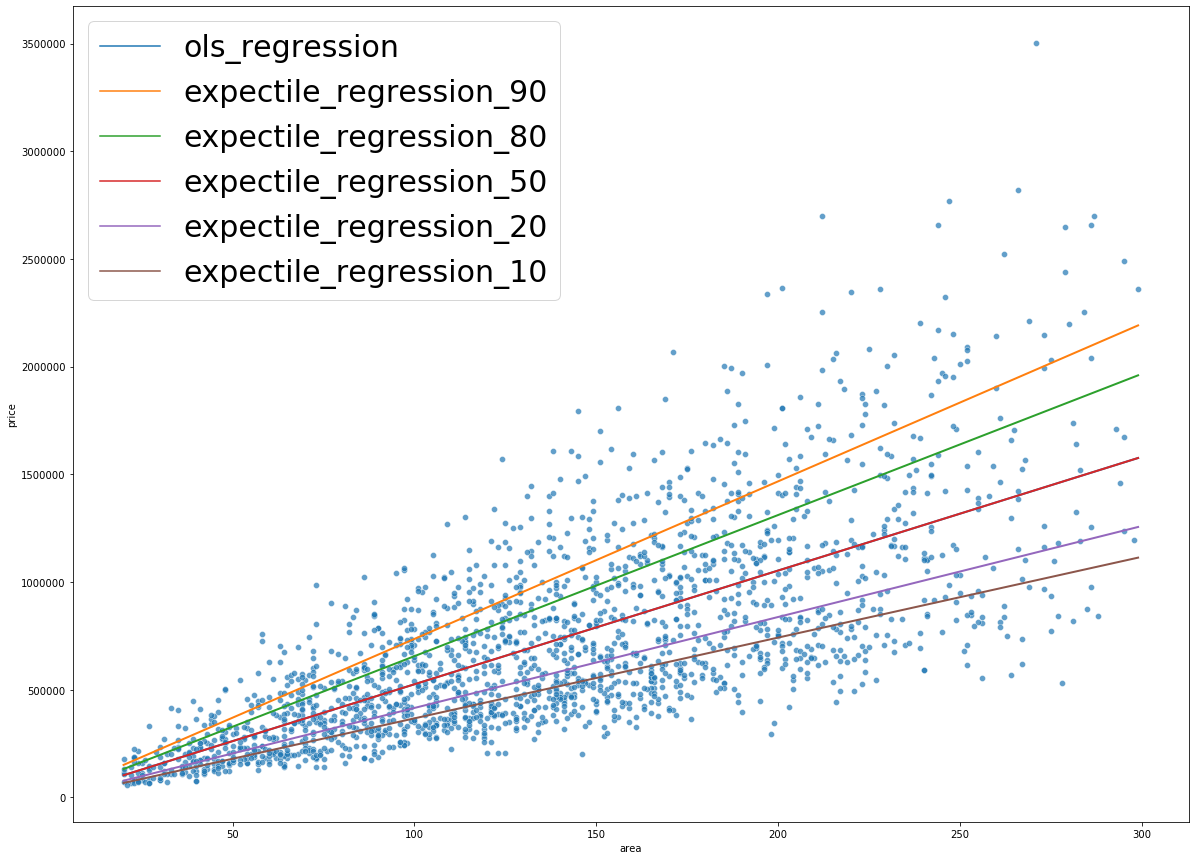

In [15]:
models = {
    'ols_regression': LinearRegression(),
    'expectile_regression_90' : ExpectileRegression(expectile=.9),
    'expectile_regression_80' : ExpectileRegression(expectile=.8),
    'expectile_regression_50' : ExpectileRegression(expectile=.5),
    'expectile_regression_20' : ExpectileRegression(expectile=.2),
    'expectile_regression_10' : ExpectileRegression(expectile=.1)
}

linear_models(
    data     = data, 
    models   = models, 
    features = ['area'], 
    target   = ['price'], 
    save     = 'img/linear_models_with_expectile_1.png'
)

/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


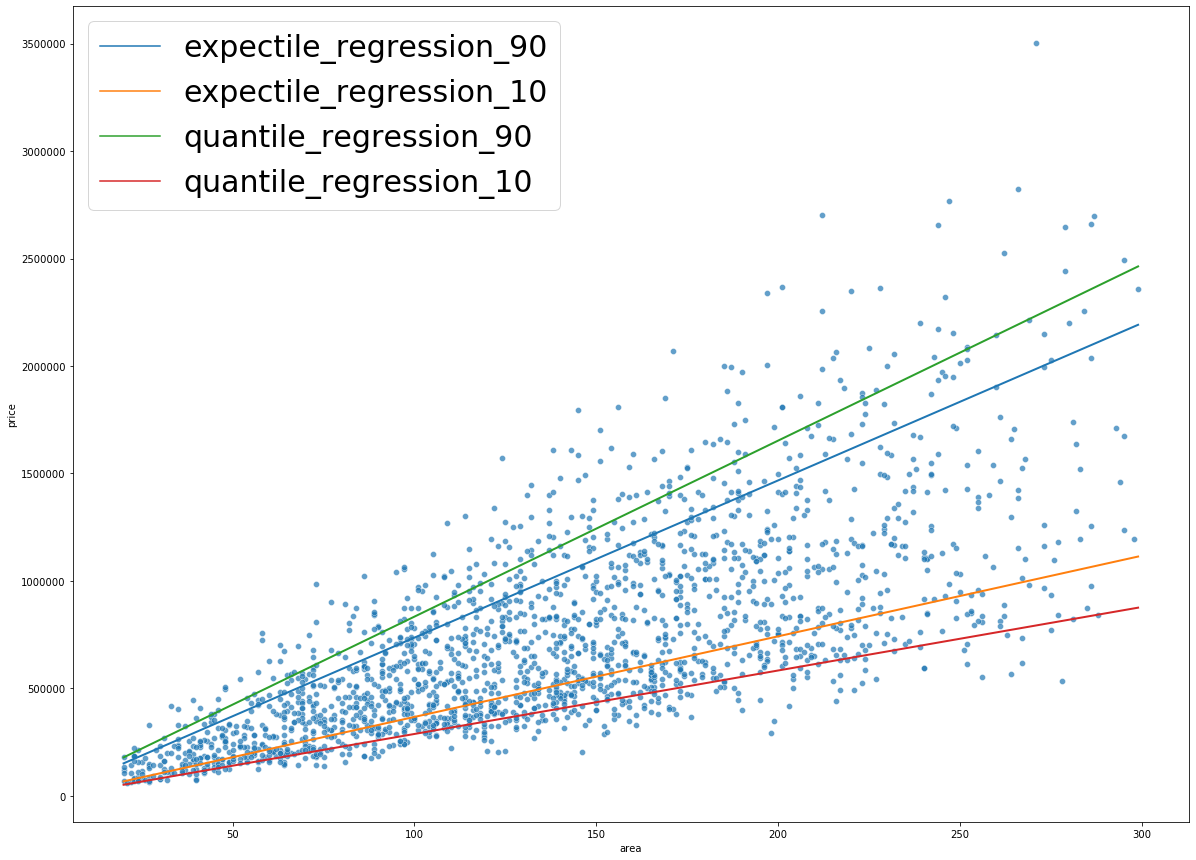

In [16]:
models = {
    'expectile_regression_90' : ExpectileRegression(expectile=.9),
    'expectile_regression_10' : ExpectileRegression(expectile=.1),
    'quantile_regression_90': QuantileRegression(quantile=.9),
    'quantile_regression_10': QuantileRegression(quantile=.1),
}

linear_models(
    data     = data, 
    models   = models, 
    features = ['area'], 
    target   = ['price'], 
    save     = 'img/linear_models_with_expectile_2.png'
)

In [122]:
def expectile_grad(beta, X, y, e):
    y_hat = X @ beta
    errors = y - y_hat
    # uśredniamy gradient po przykładach?
    return -2 * X @ np.where(errors < 0, 1 - e , e) * errors

In [123]:
y_hat = exp_reg.predict(data[['area']])
y = data[['price']].values
errors = y.reshape(-1, 1) - y_hat.reshape(-1, 1)
e = .2
X = data[['area']].values

second = np.where(errors < 0, 1 - e , e) * errors
second.shape

# X @ 
X.shape

(2000, 1)

## Further readings

## Bibliography

http://www.sp.unipg.it/surwey/images/workshop/nikos/Session-1_Pisa_July-2016.pdf